# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Random
using PyPlot
using LinearAlgebra

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))    
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
alpha_eps = 0.25
alpha_L = 0.11;

In [6]:
target = TuringTarget(funnel_model; d=d, compute_MAP=false)
true_target = TuringTarget(true_model; d=d, compute_MAP=false);

In [17]:
spl = MCHMC(0.0, alpha_L*sqrt(d); varE_wanted=0.001, sigma=ones(d))
initial_x = zeros(21)
@time  samples_mchmc = Sample(spl, target, 50_000;
                       initial_x = initial_x, #If you wish to start from a given point
                       burn_in=5_000, dialog=false);

[ Info: Using provided initial point
[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Initial nu 0.5464304300550348
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 1
[ Info: Found eps: 0.30250518390627135 ✅
[ Info: Final nu 0.3324400402982688


  2.710191 seconds (16.25 M allocations: 6.108 GiB, 27.78% gc time, 23.97% compilation time)


In [18]:
spl = MCHMC(0.8, alpha_L*sqrt(d), 10; varE_wanted=0.001, sigma=ones(d))
initial_x = zeros(10, 21)    
@time samples_mchmc_ensemble = Sample(spl, target, 5_000;
                       initial_x = initial_x, #If you wish to start from a given point
                       burn_in=500, dialog=false);

[ Info: Using provided initial point
[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅
[ Info: Initial nu 1.0443676407782818
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 3
[ Info: Final nu 1.0443676407782818


  2.953872 seconds (22.94 M allocations: 3.235 GiB, 14.93% gc time)


In [9]:
true_spl = MCHMC(0.8, alpha_L*sqrt(d); init_eps=0.3, varE_wanted=0.01, sigma=ones(d))
@time truth_mchmc = Sample(true_spl, true_target, 50_000;
               burn_in=5_000, dialog=false);

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅
[ Info: Initial nu 1.0443676407782818
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 1
[ Info: Final nu 1.0443676407782818


  2.571289 seconds (14.55 M allocations: 5.968 GiB, 29.84% gc time, 9.51% compilation time)


In [10]:
esss, rhats = Summarize(samples_mchmc)
mean(esss)/2.7

855.0493547233602

In [11]:
esss, rhats =  Summarize(samples_mchmc_ensemble)
mean(esss)/3.7

1166.0983900782123

In [12]:
theta_mchmc = [sample[1] for sample in samples_mchmc]
x10_mchmc = [sample[10+1] for sample in samples_mchmc]
E = [sample[end-1] for sample in samples_mchmc];

In [13]:
theta_mchmc_ensemble = [sample[1] for sample in samples_mchmc_ensemble]
x10_mchmc_ensemble = [sample[10+1] for sample in samples_mchmc_ensemble];

In [14]:
true_theta_mchmc = [sample[1] for sample in truth_mchmc]
true_x10_mchmc = [sample[10+1] * exp(sample[1]/2) for sample in truth_mchmc];

In [15]:
VarE = std(E)^2/d

9.622995625345109

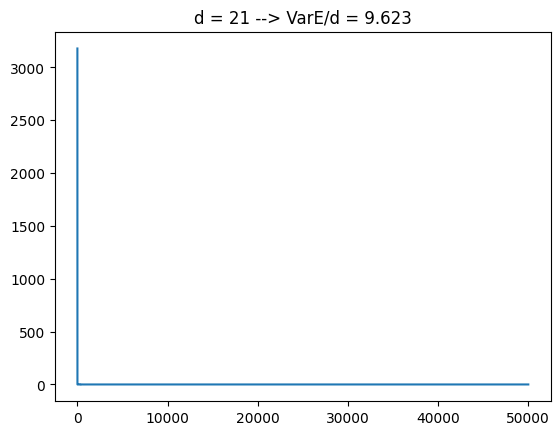

PyObject Text(0.5, 1.0, 'd = 21 --> VarE/d = 9.623')

In [16]:
plt.plot(E, label="E/d")
plt.title(string("d = ", d, " --> VarE/d = ", round(VarE, digits=5)))

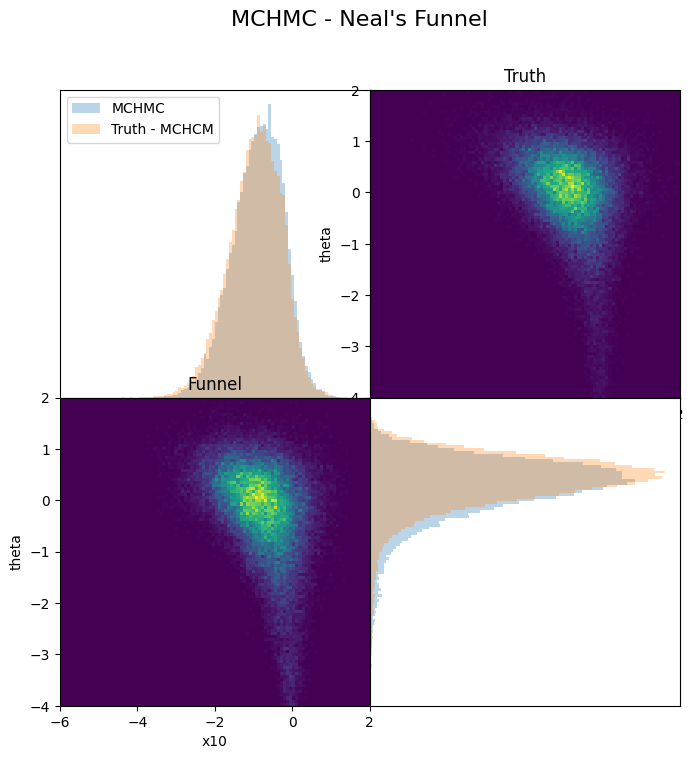

In [145]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="MCHMC")
axis[1,1].hist(true_x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, density=true, label="Truth - MCHCM")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].hist(true_theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3, density=true)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_mchmc, true_theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

## NUTS

In [71]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:01


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 64.07 seconds
Compute duration  = 64.07 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0245    0.7922     0.0035    0.0137    2845.7637    1.0007   ⋯
        z[1]    0.3687    0.7158     0.0032    0.0031   57196.3819    1.0000   ⋯
        z[2]   -0.3557    0.7142     0.0032    0.0031   56328.1240    1.0000   ⋯
        z[3]   -0.6

In [126]:
esss, rhat = Summarize(permutedims(samples_hmc.value.data, (1,3,2)))
mean(esss[1:21])/64

634.8164426153994

In [15]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:39


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 44.21 seconds
Compute duration  = 44.21 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

           θ   -0.0498    0.8665     0.0039    0.0089    9925.7412    1.0000   ⋯
        z[1]    0.3425    0.7113     0.0032    0.0025   85892.8509    1.0000   ⋯
        z[2]   -0.3330    0.7041     0.0031    0.0025   87843.3238    1.0000   ⋯
        z[3]   -0.6

In [21]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


LoadError: UndefVarError: `samples_hmc` not defined

In [22]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


In [18]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="Truth - NUTS")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("Truth")

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("Funnel")
;

LoadError: UndefVarError: `x10_hmc` not defined

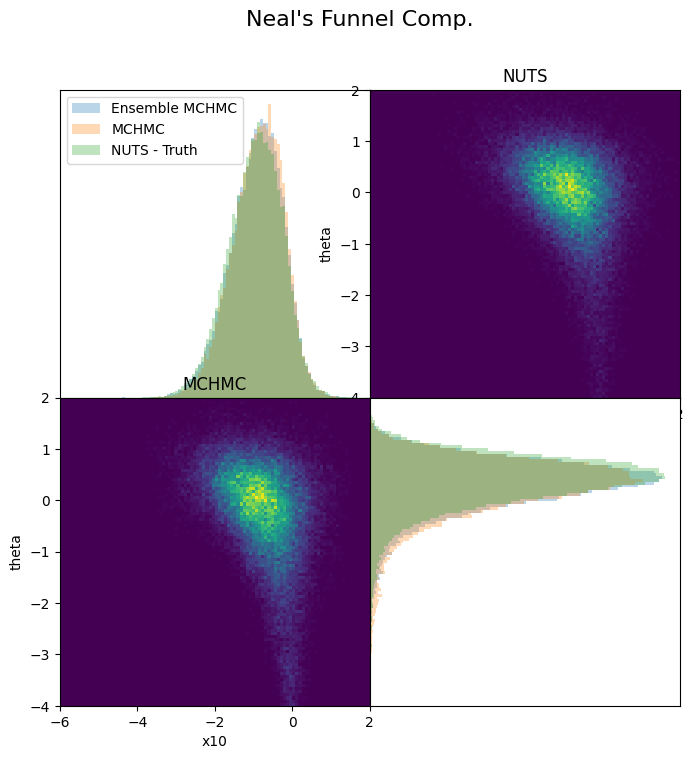

In [146]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc_ensemble, bins=100, range=[-6,2], alpha = 0.3, label="Ensemble MCHMC")
axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(true_x10_hmc, bins=100, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc_ensemble, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100,  orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")
;